In [1]:
import tensorflow as tf
from donkey import Donkey
from model import Model
from meta import Meta
%pylab inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
path_to_eval_tfrecords_file = '/mnt/c/Users/zding/Pictures/spartan/data/test.tfrecords'
batch_size = 16

In [3]:
meta = Meta()
meta.load('/mnt/c/Users/zding/Pictures/spartan/data/meta.json')

In [4]:
image_batch, length_batch, digits_batch = Donkey.build_batch(path_to_eval_tfrecords_file, batch_size=batch_size, num_examples=meta.num_test_examples, shuffled=False)
length_logits, digits_logits = Model.inference(image_batch, drop_rate=0.0)
length_predictions = tf.argmax(length_logits, axis=1)
digits_predictions = tf.argmax(digits_logits, axis=2)
digits_batch_string = tf.reduce_join(tf.as_string(digits_batch), axis=1)
digits_predictions_string = tf.reduce_join(tf.as_string(digits_predictions), axis=1)

In [7]:
image_batch.eval()

array([[[[ 0.17647064,  0.23921573,  0.32549024],
         [ 0.17647064,  0.23921573,  0.32549024],
         [ 0.17647064,  0.23921573,  0.32549024],
         ...,
         [ 0.1686275 ,  0.22352946,  0.27058828],
         [ 0.1686275 ,  0.22352946,  0.27058828],
         [ 0.1686275 ,  0.22352946,  0.27058828]],

        [[ 0.17647064,  0.23921573,  0.32549024],
         [ 0.17647064,  0.23921573,  0.32549024],
         [ 0.17647064,  0.23921573,  0.32549024],
         ...,
         [ 0.1686275 ,  0.22352946,  0.27058828],
         [ 0.1686275 ,  0.22352946,  0.27058828],
         [ 0.1686275 ,  0.22352946,  0.27058828]],

        [[ 0.17647064,  0.23921573,  0.32549024],
         [ 0.17647064,  0.23921573,  0.32549024],
         [ 0.17647064,  0.23921573,  0.32549024],
         ...,
         [ 0.1686275 ,  0.22352946,  0.27058828],
         [ 0.1686275 ,  0.22352946,  0.27058828],
         [ 0.1686275 ,  0.22352946,  0.27058828]],

        ...,

        [[ 0.26274514,  0.3176471 ,  0

In [6]:
sess = tf.InteractiveSession()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [8]:
restorer = tf.train.Saver()
checkpoint_path = tf.train.latest_checkpoint('/mnt/c/Users/zding/Pictures/spartan/data/')
restorer.restore(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from /mnt/c/Users/zding/Pictures/spartan/data/latest.ckpt


In [9]:
length_predictions_val, digits_predictions_string_val, image_batch_val = sess.run([length_predictions, digits_predictions_string, image_batch])
image_batch_val = (image_batch_val / 2.0) + 0.5

In [10]:
idx = 1
image_val = image_batch_val[idx]
length_prediction_val = length_predictions_val[idx]
digits_prediction_string_val = digits_predictions_string_val[idx]

length: 1
digits: b'310101010'


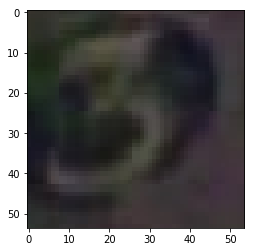

In [11]:
imshow(image_val)
print ('length: %d' % length_prediction_val)
print ('digits: %s' % digits_prediction_string_val)

In [10]:
coord.request_stop()
coord.join(threads)
sess.close()

In [ ]:
def convert_to_tfrecords(path_to_dataset_dir_and_digit_struct_mat_file_tuples,
                         path_to_tfrecords_files, choose_writer_callback):
    num_examples = []
    writers = []

    for path_to_tfrecords_file in path_to_tfrecords_files:
        num_examples.append(0)
        writers.append(tf.python_io.TFRecordWriter(path_to_tfrecords_file))

    for path_to_dataset_dir, path_to_digit_struct_mat_file in path_to_dataset_dir_and_digit_struct_mat_file_tuples:
        path_to_image_files = tf.gfile.Glob(os.path.join(path_to_dataset_dir, '*.png'))
        total_files = len(path_to_image_files)
        print ('%d files found in %s' % (total_files, path_to_dataset_dir))

        with h5py.File(path_to_digit_struct_mat_file, 'r') as digit_struct_mat_file:
            example_reader = ExampleReader(path_to_image_files)
            for index, path_to_image_file in enumerate(path_to_image_files):
                print ('(%d/%d) processing %s' % (index + 1, total_files, path_to_image_file))

                example = example_reader.read_and_convert(digit_struct_mat_file)
                if example is None:
                    break

                idx = choose_writer_callback(path_to_tfrecords_files)
                writers[idx].write(example.SerializeToString())
                num_examples[idx] += 1

    for writer in writers:
        writer.close()

    return num_examples

In [16]:
import os
import numpy as np
from PIL import Image
num_examples = []
writers = []
imgpath='/mnt/c/Users/zding/Pictures/spartan/data/ocr/'
path_to_tfrecords_file='/mnt/c/Users/zding/Pictures/spartan/data/test2.tfrecords'
num_examples.append(0)
writers.append(tf.python_io.TFRecordWriter(path_to_tfrecords_file))
path_to_image_files = tf.gfile.Glob(os.path.join(imgpath, '*.jpg'))

In [17]:
path_to_image_files

['/mnt/c/Users/zding/Pictures/spartan/data/ocr/1_105-crop1.jpg',
 '/mnt/c/Users/zding/Pictures/spartan/data/ocr/1_13-crop0.jpg',
 '/mnt/c/Users/zding/Pictures/spartan/data/ocr/1_63-crop0.jpg',
 '/mnt/c/Users/zding/Pictures/spartan/data/ocr/2_63-crop0.jpg',
 '/mnt/c/Users/zding/Pictures/spartan/data/ocr/31.jpg']

In [22]:
for fle in path_to_image_files:
    im = Image.open(fle)
    im = np.array(im.resize((64,64))).tobytes()
    feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[im]))
    example = tf.train.Example(features=tf.train.Features(feature={'image': feature}))
    writers.append(tf.python_io.TFRecordWriter(path_to_tfrecords_file))
    idx = 0
    writers[idx].write(example.SerializeToString())
    num_examples[idx] += 1

In [24]:
data_path= '/mnt/c/Users/zding/Pictures/spartan/data/test2.tfrecords'
reader = tf.TFRecordReader()
filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
_, serialized_example = reader.read(filename_queue)

In [27]:
features = tf.parse_single_example(
    serialized_example,
    features={
        'image': tf.FixedLenFeature([], tf.string)
    })

In [28]:
features['image']

<tf.Tensor 'ParseSingleExample_2/Squeeze_image:0' shape=() dtype=string>

In [ ]:
tf.decode_raw(features['image'], tf.uint8).eval()

In [13]:
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.multiply(tf.subtract(image, 0.5), 2)
image = tf.reshape(image, [64, 64, 3])
image = tf.random_crop(image, [54, 54, 3])
length_predictions_val, digits_predictions_string_val, image_batch_val = sess.run([length_predictions, digits_predictions_string, image_batch])
image_batch_val = (image_batch_val / 2.0) + 0.5

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.5058824 , 0.54509807, 0.54901963],
        [0.5058824 , 0.54509807, 0.54901963],
        [0.5058824 , 0